In [308]:
import ccxt
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [412]:
creds = json.loads(open('../creds.json', 'r').read())

In [423]:
exchange = ccxt.binance(creds['binance'])
# exchange = ccxt.phemex(creds['phemex'])

In [424]:
exchange.rateLimit

500

In [425]:
exchange.enableRateLimit = True

## We fetch the last BTC tickers from Binance

In [426]:
from datetime import timezone 
import datetime
dt = datetime.datetime.now()   
utc_time = dt.replace(tzinfo = timezone.utc) 
utc_timestamp = utc_time.timestamp() 
  
timestamp = utc_timestamp
# timestamp *= 1000

In [427]:
timestamp

1615246367.111876

In [432]:
candles = np.array(exchange.fetch_ohlcv("BTC/USDT", '5m'))
n = candles.shape[0]

In [433]:
candles

array([[1.61509290e+12, 4.94837800e+04, 4.95435700e+04, 4.94361800e+04,
        4.94361800e+04, 1.21411058e+02],
       [1.61509320e+12, 4.94361800e+04, 4.94592500e+04, 4.92130700e+04,
        4.92507800e+04, 1.86309018e+02],
       [1.61509350e+12, 4.92483300e+04, 4.92919200e+04, 4.91111100e+04,
        4.92316100e+04, 2.44494877e+02],
       ...,
       [1.61524200e+12, 5.17235200e+04, 5.17300000e+04, 5.15558900e+04,
        5.15703100e+04, 1.44511388e+02],
       [1.61524230e+12, 5.15695500e+04, 5.16000500e+04, 5.13000000e+04,
        5.15827200e+04, 3.60464015e+02],
       [1.61524260e+12, 5.15868000e+04, 5.16486400e+04, 5.15269400e+04,
        5.16420000e+04, 2.00829919e+02]])

In [430]:
for _ in range(4):
    candles2 = np.array(exchange.fetch_ohlcv("BTC/USDT", '1h', int(candles[0, 0] - n * 60 * 60 * 1000)))
    candles = np.vstack([candles2, candles])

In [434]:
data = pd.DataFrame()
data['timestamp'] = candles[:, 0]
data['date'] = pd.to_datetime(data['timestamp'] * 1000000)
data['open'] = candles[:, 1]
data['high'] = candles[:, 2]
data['low'] = candles[:, 3]
data['close'] = candles[:, 4]
data['volume'] = candles[:, 5]

## MACD calculation

In [435]:
ewm12 = data['close'].ewm(span=12, adjust=False).mean()
ewm26 = data['close'].ewm(span=26, adjust=False).mean()
macd = ewm12 - ewm26
macd9 = macd.ewm(span=9, adjust=False).mean()
data['macd'] = macd
data['macd9'] = macd9

In [436]:
data

,timestamp,date,open,high,low,close,volume,macd,macd9
0,1.615093e+12,2021-03-07 04:55:00,49483.78,49543.57,49436.18,49436.18,121.411058,0.000000,0.000000
1,1.615093e+12,2021-03-07 05:00:00,49436.18,49459.25,49213.07,49250.78,186.309018,-14.789744,-2.957949
2,1.615094e+12,2021-03-07 05:05:00,49248.33,49291.92,49111.11,49231.61,244.494877,-27.737836,-7.913926
3,1.615094e+12,2021-03-07 05:10:00,49231.60,49286.00,49175.00,49182.05,137.321391,-41.519757,-14.635092
4,1.615094e+12,2021-03-07 05:15:00,49182.04,49280.30,49176.51,49244.08,138.136843,-46.896136,-21.087301
...,...,...,...,...,...,...,...,...,...
495,1.615241e+12,2021-03-08 22:10:00,51752.99,51759.96,51603.03,51630.96,144.560483,101.590555,125.664823
496,1.615242e+12,2021-03-08 22:15:00,51630.93,51738.51,51626.54,51723.51,105.156110,95.881985,119.708255
497,1.615242e+12,2021-03-08 22:20:00,51723.52,51730.00,51555.89,51570.31,144.511388,78.095704,111.385745
498,1.615242e+12,2021-03-08 22:25:00,51569.55,51600.05,51300.00,51582.72,360.464015,64.260575,101.960711


## MACD crossovers calculations

In [437]:
macd9_shifted = data['macd9'].shift(1)
macd_shifted = data['macd'].shift(1)

crossovers_buy = (macd_shifted < macd9_shifted) & (data['macd'] >= data['macd9'])
data['crossover_buy'] = crossovers_buy

crossovers_sell = (macd_shifted > macd9_shifted) & (data['macd'] <= data['macd9'])
data['crossover_sell'] = crossovers_sell

## Plotting everything

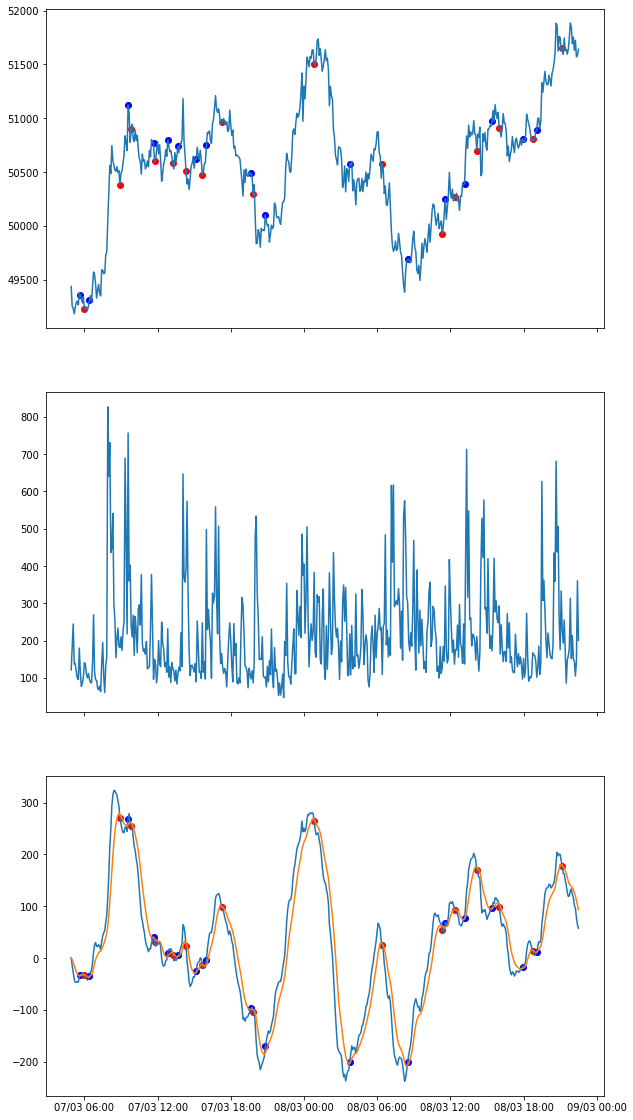

In [438]:
import matplotlib.dates as mdates
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 20))
ax1.plot(data['date'], data['close'])
ax2.plot(data['date'], data['volume'])
ax3.plot(data['date'], data['macd'])
ax3.plot(data['date'], data['macd9'])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))

for index, row in data.iterrows():
    if (row['crossover_buy']):
        ax3.scatter(row['date'], row['macd'], color='b')
        ax1.scatter(row['date'], row['close'], color='b')
    if (row['crossover_sell']):
        ax3.scatter(row['date'], row['macd'], color='r')
        ax1.scatter(row['date'], row['close'], color='r')

plt.show()

## Calculating estimated profit

In [439]:
profits = []
taker_fee = 0.1

last_buy = None
for index, row in data.iterrows():
    if (row['crossover_buy'] and not last_buy):
        last_buy = (row['open'] + row['close']) / 2
        print("Buy @{:.2f}".format(last_buy))
    if (row['crossover_sell'] and last_buy):
        price = (row['open'] + row['close']) / 2
        variation = (price - last_buy) / last_buy * 100
        profits.append(variation - taker_fee)
        last_buy = None
        print("Sell @{:.2f}, profit {:.2f}".format(price, profits[-1]))
print("Total: {:.2f}".format(np.array(profits).sum()))

Buy @49369.95
Sell @49284.10, profit -0.27
Buy @49285.25
Sell @50446.74, profit 2.26
Buy @50911.31
Sell @50836.56, profit -0.25
Buy @50770.68
Sell @50683.01, profit -0.27
Buy @50720.85
Sell @50612.54, profit -0.31
Buy @50692.89
Sell @50585.07, profit -0.31
Buy @50619.29
Sell @50536.65, profit -0.26
Buy @50668.18
Sell @50952.54, profit 0.46
Buy @50479.55
Sell @50370.55, profit -0.32
Buy @50027.06
Sell @51569.85, profit 2.98
Buy @50496.10
Sell @50507.47, profit -0.08
Buy @49680.72
Sell @49985.88, profit 0.51
Buy @50188.58
Sell @50264.62, profit 0.05
Buy @50388.40
Sell @50771.65, profit 0.66
Buy @50948.18
Sell @50984.00, profit -0.03
Buy @50779.76
Sell @50798.64, profit -0.06
Buy @50885.97
Sell @51640.92, profit 1.38
Total: 6.14


In [440]:
len(profits) / (data.shape[0] / 60)

2.04

In [441]:
np.array(profits).mean()

0.36134843379765325

# Fetch balance

In [442]:
balance = exchange.fetch_balance()

In [443]:
balance['USDT']['total']

100.0

# Tweeting

In [411]:
import tweepy

In [413]:
auth = tweepy.OAuthHandler(creds['twitter']['apiKey'], 
    creds['twitter']['secret'])
auth.set_access_token(creds['twitter']['accessToken'], 
    creds['twitter']['accessTokenSecret'])

api = tweepy.API(auth)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [414]:
api.update_status("Hello! This tweet is sent from a #Python notebook :)")

Status(_api=<tweepy.api.API object at 0x1187a88b0>, _json={'created_at': 'Mon Mar 08 22:03:27 +0000 2021', 'id': 1369046127404810244, 'id_str': '1369046127404810244', 'text': 'Hello! This tweet is sent from a #Python notebook :)', 'truncated': False, 'entities': {'hashtags': [{'text': 'Python', 'indices': [33, 40]}], 'symbols': [], 'user_mentions': [], 'urls': []}, 'source': '', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1369041402995281922, 'id_str': '1369041402995281922', 'name': 'MACD crypto bot', 'screen_name': 'bot_macd', 'location': '', 'description': "I'm a bot.\nI buy every MACD crossover on $BTC.\nI tweet my trades and current balance.\nMy father is @AirM4rx.\n#btc", 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 0, 'friends_count': 1, 'listed_count': 0, 'created_at': 'Mon Mar 08 21:44:56 +0000 2021

Tweet with matplotlib visualization

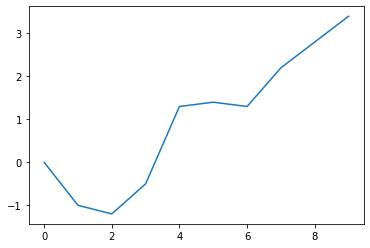

In [420]:
# Random matplotlib graph
x = list(range(10))
y = [0, -1, -1.2, -0.5, 1.3, 1.4, 1.3, 2.2, 2.8, 3.4]

plt.plot(x, y)
plt.savefig("/tmp/vis.png")

In [421]:
media = api.media_upload("/tmp/vis.png")
tweet = "Testing to tweet a #matplotlib graph!!!"
post_result = api.update_status(status=tweet, media_ids=[media.media_id])